In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Importing all the necessary modules for Deepfake detection
from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [256, 256]

# training config:
epochs = 40
batch_size = 32

In [ ]:
#define paths
real_path =  r'/content/drive/MyDrive/Original_Images/real'
fake_path =  r'/content/drive/MyDrive/Original_Images/fake'
# Use glob to grab images from path .jpg or jpeg
real_files_pr  = glob(real_path + '/*')
fake_files_pre = glob(fake_path + '/*')
# Taking 500 images of each category
real_files=real_files_pr[0:2000]

fake_files =fake_files_pre[0:2000]

In [ ]:
# Visualize file variable contents
print("First 5 real Files: ",real_files[0:5])
print("Total Count: ",len(real_files))
print("First 5 fake Files: ",fake_files[0:5])
print("Total Count: ",len(fake_files))


First 5 real Files:  ['/content/drive/MyDrive/Original_Images/real/61499.png', '/content/drive/MyDrive/Original_Images/real/61498.png', '/content/drive/MyDrive/Original_Images/real/61497.png', '/content/drive/MyDrive/Original_Images/real/61496.png', '/content/drive/MyDrive/Original_Images/real/61495.png']
Total Count:  2000
First 5 fake Files:  ['/content/drive/MyDrive/Original_Images/fake/photo_3004.jpg', '/content/drive/MyDrive/Original_Images/fake/photo_3005.jpg', '/content/drive/MyDrive/Original_Images/fake/photo_3006.jpg', '/content/drive/MyDrive/Original_Images/fake/photo_3007.jpg', '/content/drive/MyDrive/Original_Images/fake/photo_3008.jpg']
Total Count:  2000


In [ ]:
# Fetch Images and Class Labels from Files
real_labels = []
fake_labels = []

real_images=[]
fake_images=[]

In [ ]:
for i in range(len(real_files)):
  image = cv2.imread(real_files[i]) # read file
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(256,256)) # resize as per model
  real_images.append(image) # append image
  real_labels.append('REAL') #append class label
for i in range(len(fake_files)):
  image = cv2.imread(fake_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(256,256))
  fake_images.append(image)
  fake_labels.append(  'FAKE')


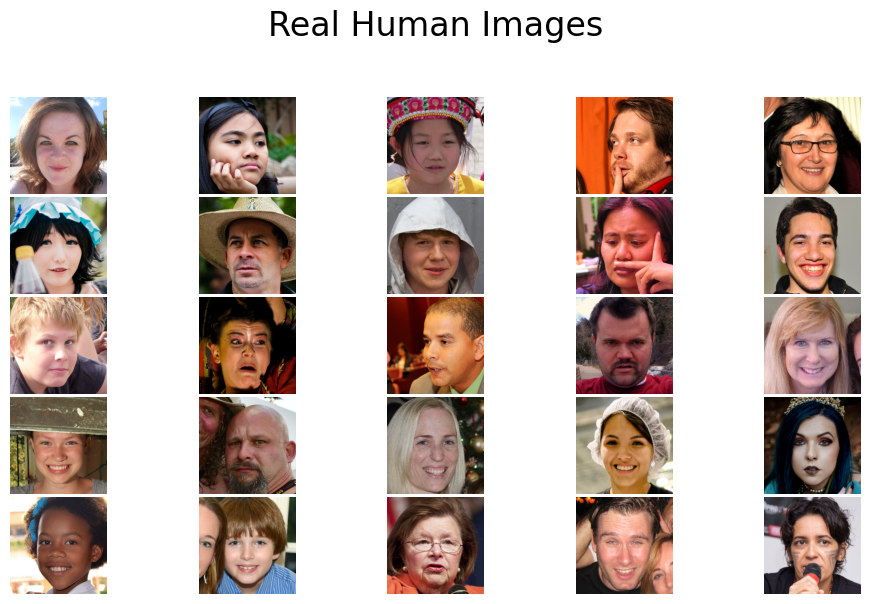

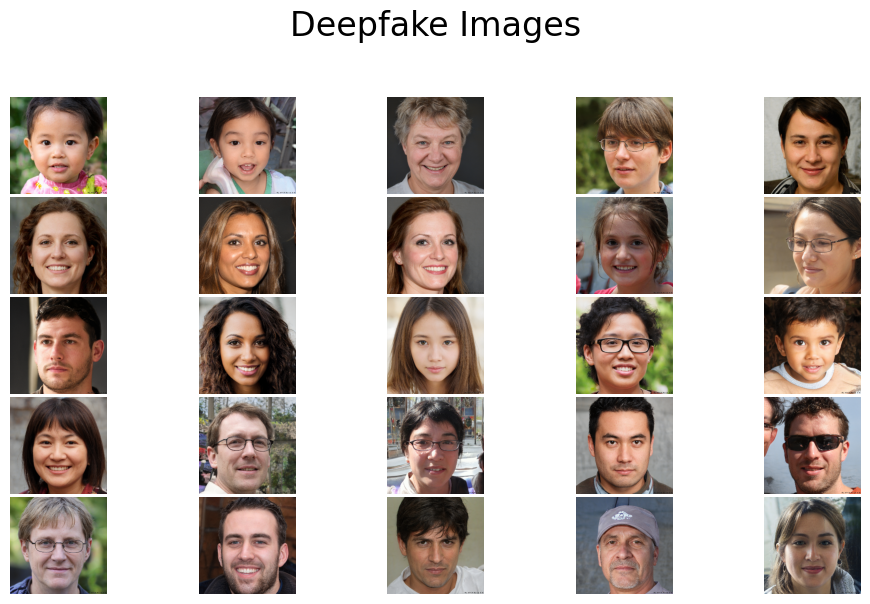

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 5
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(real_images, 'Real Human Images')

plot_images(fake_images, 'Deepfake Images')


In [ ]:
# Convert to array and Normalize to interval of [0,1]
real_images = np.array(real_images) / 255
fake_images = np.array(fake_images) / 255


In [ ]:
# Split into training and testing sets for both types of images
real_x_train, real_x_test, real_y_train, real_y_test = train_test_split(
    real_images, real_labels, test_size=0.2)
fake_x_train, fake_x_test, fake_y_train, fake_y_test = train_test_split(
    fake_images, fake_labels, test_size=0.2)

In [ ]:
# Merge sets for both types of images
X_train = np.concatenate((fake_x_train, real_x_train), axis=0)
X_test = np.concatenate((fake_x_test, real_x_test), axis=0)
y_train = np.concatenate((fake_y_train, real_y_train), axis=0)
y_test = np.concatenate((fake_y_test, real_y_test), axis=0)


In [ ]:
# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

plot_images(real_x_train, 'X_train')
plot_images(real_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing REAL and FAKE for X_train and X_test

In [ ]:
# Building CNN Model
from tensorflow.keras.models import Sequential
model =Sequential()


In [ ]:
# Build Model

# Convolutional Layer1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Max Pooling Layer1
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer2
model.add(Conv2D(64, (3, 3), activation='relu'))

# Max Pooling Layer2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer3
model.add(Conv2D(128, (3, 3), activation='relu'))

# Max Pooling Layer3
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer4
model.add(Conv2D(256, (5, 5), activation='relu'))

# Max Pooling Layer4
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

# Dense Layer1
model.add(Dense(512, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))
# Dense Layer2
model.add(Dense(256, activation='relu'))

# Dropout layer
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(2, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Print the model summary
model.summary()

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [ ]:

history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/40
100/100 [==============================] - 109s 1s/step - loss: 0.7253 - accuracy: 0.5263 - val_loss: 0.6690 - val_accuracy: 0.5000
Epoch 2/40
100/100 [==============================] - 101s 1s/step - loss: 0.6636 - accuracy: 0.6081 - val_loss: 0.6386 - val_accuracy: 0.6500
Epoch 3/40
100/100 [==============================] - 101s 1s/step - loss: 0.6397 - accuracy: 0.6400 - val_loss: 0.5964 - val_accuracy: 0.7113
Epoch 4/40
100/100 [==============================] - 103s 1s/step - loss: 0.6261 - accuracy: 0.6616 - val_loss: 0.6336 - val_accuracy: 0.6313
Epoch 5/40
100/100 [==============================] - 100s 998ms/step - loss: 0.6234 - accuracy: 0.6681 - val_loss: 0.5701 - val_accuracy: 0.7038
Epoch 6/40
100/100 [==============================] - 103s 1s/step - loss: 0.6081 - accuracy: 0.6731 - val_loss: 0.5655 - val_accuracy: 0.7013
Epoch 7/40
100/100 [==============================] - 102s 1s/step - loss: 0.6129 - accuracy: 0.6644 - val_loss: 0.6171 - val_accuracy: 0.6

In [ ]:
# Save Model and Weights
model.save('Deepfake_CNN_M1.h5')
model.save_weights('Deepfake_weights_M1.hdf5')

In [ ]:
# Load saved model
model = load_model('Deepfake_CNN_M1.h5')

25/25 [==============================] - 4s 169ms/step


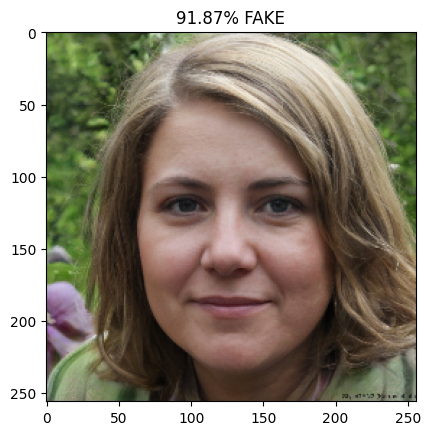

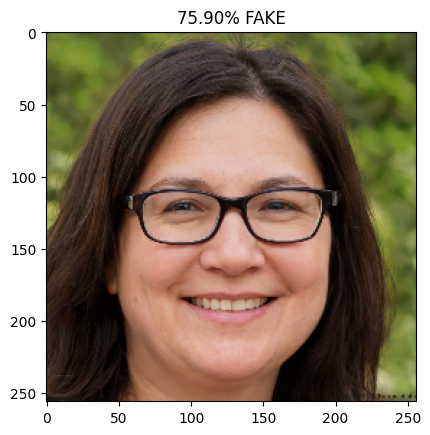

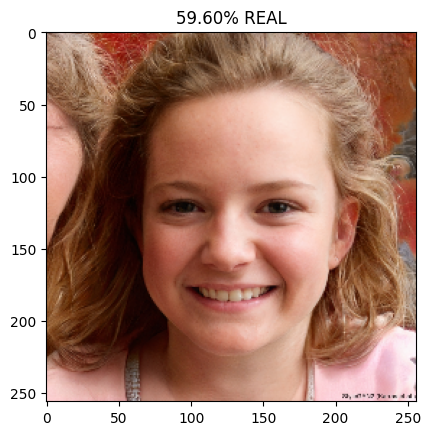

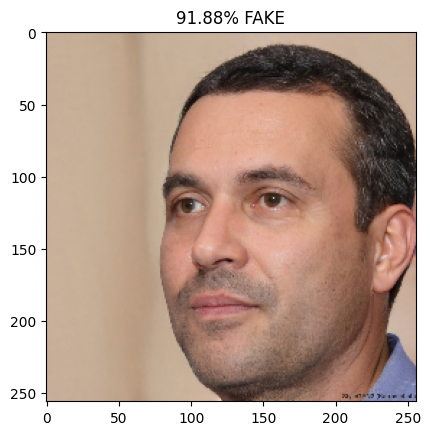

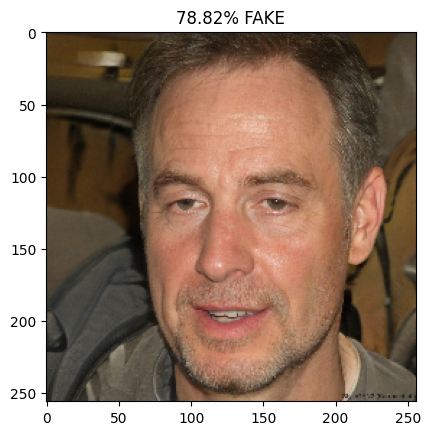

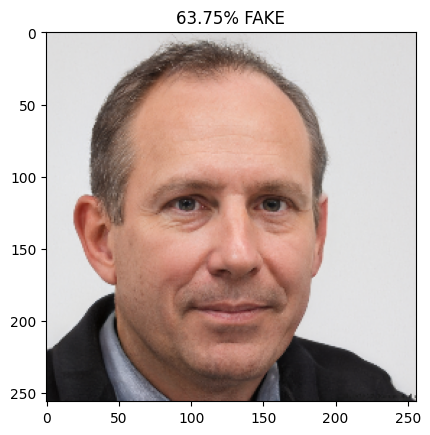

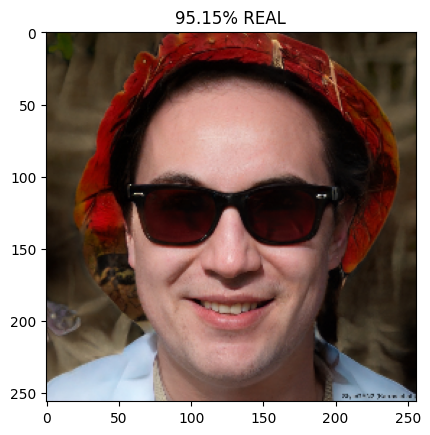

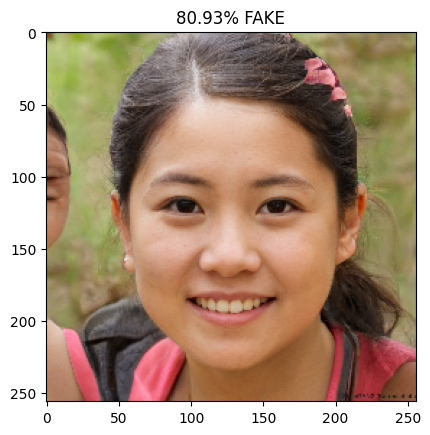

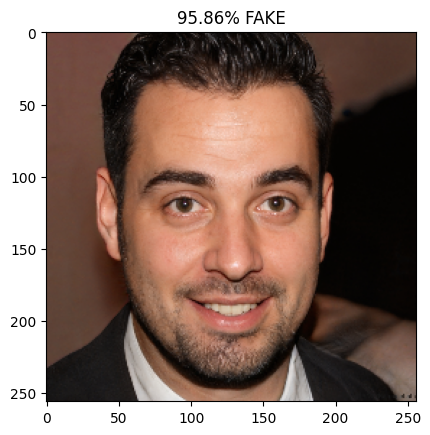

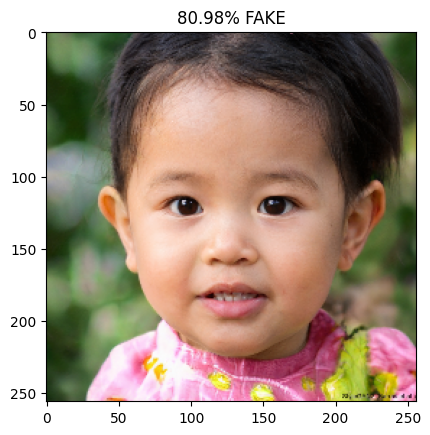

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% REAL')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% FAKE')
  plt.imshow(X_test[index])
  plt.show()


In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)


In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc=metrics.auc(fpr,tpr)
print("Auc= {:.2f}".format(auc*100))

Auc= 78.88


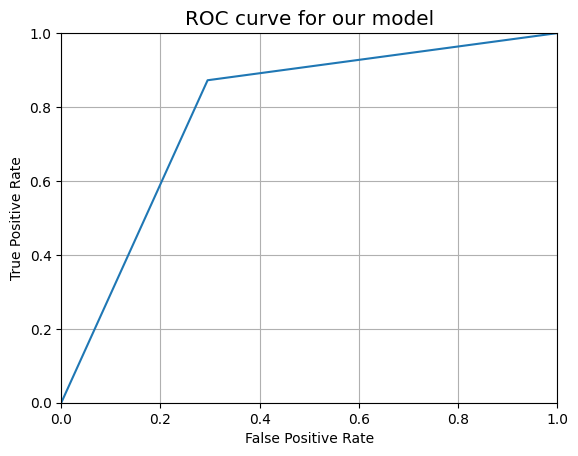

In [ ]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['REAL','FAKE']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion Matrix without Normalization


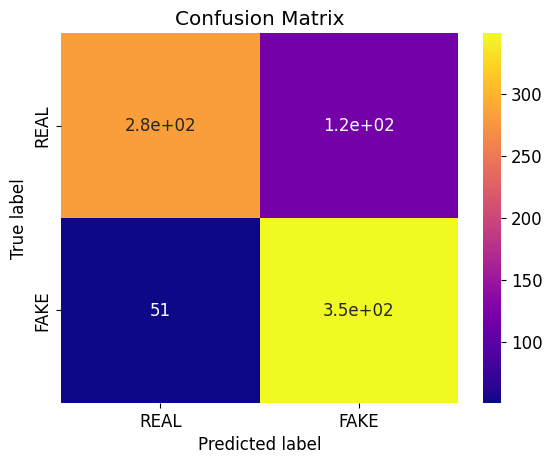

Confusion Matrix with Normalized Values


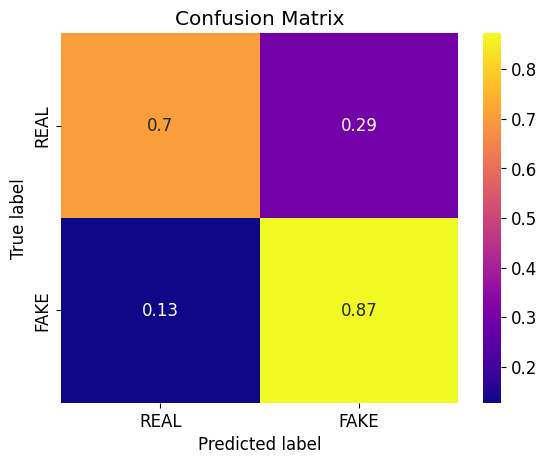

In [ ]:
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [ ]:


from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()

